In [1]:
import os
import torch
from torch import nn
from d2l import torch as d2l

/home/tian/anaconda3/envs/d2l/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


Stanford’s large movie review dataset for sentiment analysis

training set: 25000 movie reviews

testing set: 25000 movie reviews 

label: “positive” and “negative”

Reading the data

In [3]:
d2l.DATA_HUB['aclImdb'] = (d2l.DATA_URL + 'aclImdb_v1.tar.gz',
                          '01ada507287d82875905620988597833ad4e0903')

data_dir = d2l.download_extract('aclImdb', 'aclImdb')

In [4]:
#@save
def read_imdb(data_dir, is_train):
    """Read the IMDb review dataset text sequences and labels."""
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test', label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels

train_data = read_imdb(data_dir, is_train=True)
print('# trainings:', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('label:', y, 'review:', x[:60])

# [0][:]: data, [1][:]: label

# trainings: 25000
label: 1 review: Two years ago I watched "The Matador" in cinema and I loved 
label: 1 review: `Stanley and Iris' is a heart warming film about two people 
label: 1 review: Many mystery stories follow the standard whodunit path: murd


Pre-processing data

In [5]:
train_tokens = d2l.tokenize(train_data[0], token='word')    # into word level
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

In [6]:
print(train_tokens[0])

['Two', 'years', 'ago', 'I', 'watched', '"The', 'Matador"', 'in', 'cinema', 'and', 'I', 'loved', 'everything', 'about', 'this', 'movie.', 'Obviously,', 'I', 'was', 'totally', 'under', 'impression', 'of', 'Pierce', "Brosan's", 'magnificent', 'role.', 'Yesterday,', 'I', 'caught', 'this', 'movie', 'again', 'on', 'TV', 'so', 'I', 'looked', 'at', 'it', 'a', 'bit', 'deeper.', 'Now,', 'I', 'can', 'say', 'with', 'certain', 'that', 'this', 'movie', "isn't", 'that', 'special', 'but', 'you', 'just', "gotta'", 'love', 'it', 'because', 'of', 'one', 'man.', '<br', '/><br', '/>Brosnan', 'lifts', 'its', 'grade', 'up', 'in', 'my', 'opinion', 'with', 'amazing', 'performance', 'of', 'Julian', 'Noble,', 'tired', 'hit-man', 'who', 'has', 'no', 'friends.', 'Soon', 'Julian', 'meets', 'Danny', 'Wright', '(Greg', 'Kinnear)', 'in', 'Mexico', 'City,', 'man', "who's", 'got', 'bad', 'luck:', 'his', 'son', 'died', 'in', 'accident,', 'his', 'job', "isn't", 'going', 'that', 'well', 'and', "he's", 'not', 'sure', 'that

(array([ 553., 2373., 6820., 4834., 2817., 1848., 1380., 1005.,  759.,
         581.,  437.,  349.,  257.,  207.,  174.,  133.,  116.,   85.,
          75.]),
 array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.,
        550., 600., 650., 700., 750., 800., 850., 900., 950.]),
 <BarContainer object of 19 artists>)

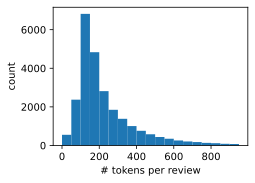

In [7]:
d2l.set_figsize()
d2l.plt.xlabel('# tokens per review')
d2l.plt.ylabel('count')
d2l.plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50))

In [8]:
# As we expected, the reviews have varying lengths. To process a minibatch of such reviews at each time, 
# we set the length of each review to 500 with truncation and padding

num_steps = 500  # sequence length
# the original d2l.truncate_pad() will discard the content when len(line) > max_length, here we want an overlapping method to include the remain content. 
train_features = torch.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
print(train_features.shape)

torch.Size([25000, 500])


In [9]:
# the original d2l.truncate_pad() will discard the content when len(line) > max_length, here we want an overlapping method to include the remain content. 
# this will increase num of training dataset

def all_data_features(train_tokens, vocab, num_steps, train_data):
    def truncating(line_o, max_length, pad_token, label):
        line = vocab[line_o]
        num_parts = (len(line) // max_length) + 1
        if num_parts == 1:
            return [line + [pad_token] * (max_length - len(line))], list([label])  # Pad
        else:
            new_lines = []
            for i in range(num_parts):
                if i * max_length + max_length > len(line):
                    new_line = line[i * max_length :]
                    new_line = new_line + [pad_token] * (max_length - len(new_line))
                else:
                    new_line = line[i * max_length : i * max_length + max_length]
                assert len(new_line) == max_length, (line[0:4], len(line), i * max_length + max_length - 1, len(new_line), line)
                new_lines.append(new_line)
            return new_lines, [label] * num_parts
    train_features = []
    train_labels = []
    for n, line in enumerate(train_tokens):
        new_lines, new_labels = truncating(line, num_steps, vocab['<pad>'], train_data[1][n])
        train_features.extend(new_lines)
        train_labels.extend(new_labels)
    
    return torch.tensor(train_features), train_labels


In [11]:
train_features, train_labels = all_data_features(train_tokens, vocab, num_steps, train_data)
train_features.shape

torch.Size([27098, 500])

Data loader

In [12]:
train_iter = d2l.load_array((train_features, torch.tensor(train_labels)), 64)

for X, y in train_iter:
    print('X:', X.shape, ', y:', y.shape)
    break
print('# batches:', len(train_iter))

X: torch.Size([64, 500]) , y: torch.Size([64])
# batches: 424


In [13]:
# all together
def load_data_imdb(batch_size, num_steps=500):
    """Return data iterators and the vocabulary of the IMDb review dataset."""
    data_dir = d2l.download_extract('aclImdb', 'aclImdb')
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    # train_features = torch.tensor([d2l.truncate_pad(
        # vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    train_features, train_labels = all_data_features(train_tokens, vocab, num_steps, train_data)
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    # train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])),
                                # batch_size)
    train_iter = d2l.load_array((train_features, torch.tensor(train_labels)),
                                batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1])),
                               batch_size,
                               is_train=False)
    return train_iter, test_iter, vocab

In [14]:
train_iter, test_iter, vocab = load_data_imdb(50)